In [3]:
import pip
def install(package):
    pip.main(['install', package])

In [9]:
install('librosa')

  Using cached joblib-0.11-py2.py3-none-any.whl
  Using cached numba-0.35.0-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached llvmlite-0.20.0-cp27-cp27mu-manylinux1_x86_64.whl


Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/usr/local/lib/python2.7/dist-packages/pip/commands/install.py", line 342, in run
    prefix=options.prefix_path,
  File "/usr/local/lib/python2.7/dist-packages/pip/req/req_set.py", line 784, in install
    **kwargs
  File "/usr/local/lib/python2.7/dist-packages/pip/req/req_install.py", line 851, in install
    self.move_wheel_files(self.source_dir, root=root, prefix=prefix)
  File "/usr/local/lib/python2.7/dist-packages/pip/req/req_install.py", line 1064, in move_wheel_files
    isolated=self.isolated,
  File "/usr/local/lib/python2.7/dist-packages/pip/wheel.py", line 345, in move_wheel_files
    clobber(source, lib_dir, True)
  File "/usr/local/lib/python2.7/dist-packages/pip/wheel.py", line 316, in clobber
    ensure_dir(destdir)
  File "/usr/local/lib/python2.7/dist-packages/pip/utils/__init__.py", line 83, 

In [21]:
import librosa
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13


In [2]:
tf.__version__

'1.3.0'

In [20]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0) # stft used
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0) # stft used
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
              mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            except Exception as e:
              print("Error encountered while parsing file: ", fn)
              continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('/')[-1].split('-')[1])
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [22]:
parent_dir = 'UrbanSound8K/audio'
tr_sub_dirs = ["fold1"]
ts_sub_dirs = ["fold3"]
tr_features, tr_labels = parse_audio_files(parent_dir,tr_sub_dirs)
ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)

tr_labels = one_hot_encode(tr_labels)
ts_labels = one_hot_encode(ts_labels)

/Users/Gundeep/anaconda3/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/Users/Gundeep/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1632: RuntimeWarning: invalid value encountered in less
  if np.any(X < 0) or np.any(X_ref < 0):
/Users/Gundeep/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1644: RuntimeWarning: invalid value encountered in maximum
  Z = np.maximum(X, X_ref).astype(dtype)
/Users/Gundeep/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1645: RuntimeWarning: invalid value encountered in less
  bad_idx = (Z < np.finfo(dtype).tiny)


Error encountered while parsing file:  UrbanSound8K/audio/fold1/87275-1-1-0.wav
Error encountered while parsing file:  UrbanSound8K/audio/fold1/87275-1-2-0.wav


In [23]:
tr_features.shape
tr_labels.shape
train_x = tr_features
train_y = tr_labels
test_x = ts_features
test_y = ts_labels

In [36]:
train_x,_,train_y,_ = train_test_split(tr_features,tr_labels,test_size=0.1, random_state=42)

In [37]:
#hyper paramters
training_epochs = 2000
n_dim = train_x.shape[1]
b_size = 50
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [38]:
Sequential = models.Sequential
Dense = layers.Dense
#numpy.random.seed(7)

In [39]:
model = Sequential()
model.add(Dense(n_hidden_units_one, input_dim=n_dim, activation='sigmoid'))
model.add(Dense(n_hidden_units_two, activation='tanh'))
model.add(Dense(n_classes, activation='softmax'))

In [40]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
model.fit(train_x, train_y, epochs=training_epochs, batch_size=b_size)

Epoch 1/2000
435/435 [==============================] - 0s - loss: 0.3017 - acc: 0.9046     
Epoch 2/2000
435/435 [==============================] - 0s - loss: 0.2289 - acc: 0.9193     
Epoch 3/2000
435/435 [==============================] - 0s - loss: 0.1778 - acc: 0.9336     
Epoch 4/2000
435/435 [==============================] - 0s - loss: 0.1419 - acc: 0.9476     
Epoch 5/2000
435/435 [==============================] - 0s - loss: 0.1180 - acc: 0.9575     
Epoch 6/2000
435/435 [==============================] - 0s - loss: 0.0973 - acc: 0.9630     
Epoch 7/2000
435/435 [==============================] - 0s - loss: 0.0804 - acc: 0.9713     
Epoch 8/2000
435/435 [==============================] - 0s - loss: 0.0599 - acc: 0.9816     
Epoch 9/2000
435/435 [==============================] - 0s - loss: 0.0477 - acc: 0.9871     
Epoch 10/2000
435/435 [==============================] - 0s - loss: 0.0381 - acc: 0.9910     
Epoch 11/2000
435/435 [==============================] - 0s - loss: 0

435/435 [==============================] - 0s - loss: 1.9390e-04 - acc: 1.0000     
Epoch 86/2000
435/435 [==============================] - 0s - loss: 1.8899e-04 - acc: 1.0000     
Epoch 87/2000
435/435 [==============================] - 0s - loss: 1.8383e-04 - acc: 1.0000     
Epoch 88/2000
435/435 [==============================] - 0s - loss: 1.8100e-04 - acc: 1.0000     
Epoch 89/2000
435/435 [==============================] - 0s - loss: 1.7638e-04 - acc: 1.0000     
Epoch 90/2000
435/435 [==============================] - 0s - loss: 1.7246e-04 - acc: 1.0000     
Epoch 91/2000
435/435 [==============================] - 0s - loss: 1.6927e-04 - acc: 1.0000     
Epoch 92/2000
435/435 [==============================] - 0s - loss: 1.6560e-04 - acc: 1.0000     
Epoch 93/2000
435/435 [==============================] - 0s - loss: 1.6267e-04 - acc: 1.0000     
Epoch 94/2000
435/435 [==============================] - 0s - loss: 1.5893e-04 - acc: 1.0000     
Epoch 95/2000
435/435 [===========

435/435 [==============================] - 0s - loss: 5.0659e-05 - acc: 1.0000     
Epoch 169/2000
435/435 [==============================] - 0s - loss: 5.0186e-05 - acc: 1.0000     
Epoch 170/2000
435/435 [==============================] - 0s - loss: 4.9462e-05 - acc: 1.0000     
Epoch 171/2000
435/435 [==============================] - 0s - loss: 4.8891e-05 - acc: 1.0000     
Epoch 172/2000
435/435 [==============================] - 0s - loss: 4.8327e-05 - acc: 1.0000     
Epoch 173/2000
435/435 [==============================] - 0s - loss: 4.7795e-05 - acc: 1.0000     
Epoch 174/2000
435/435 [==============================] - 0s - loss: 4.7211e-05 - acc: 1.0000     
Epoch 175/2000
435/435 [==============================] - 0s - loss: 4.6690e-05 - acc: 1.0000     
Epoch 176/2000
435/435 [==============================] - 0s - loss: 4.6088e-05 - acc: 1.0000     
Epoch 177/2000
435/435 [==============================] - 0s - loss: 4.5557e-05 - acc: 1.0000     
Epoch 178/2000
435/435 [=

435/435 [==============================] - 0s - loss: 2.1967e-05 - acc: 1.0000     
Epoch 251/2000
435/435 [==============================] - 0s - loss: 2.1768e-05 - acc: 1.0000     
Epoch 252/2000
435/435 [==============================] - 0s - loss: 2.1571e-05 - acc: 1.0000     
Epoch 253/2000
435/435 [==============================] - 0s - loss: 2.1387e-05 - acc: 1.0000     
Epoch 254/2000
435/435 [==============================] - 0s - loss: 2.1213e-05 - acc: 1.0000     
Epoch 255/2000
435/435 [==============================] - 0s - loss: 2.1112e-05 - acc: 1.0000     
Epoch 256/2000
435/435 [==============================] - 0s - loss: 2.0861e-05 - acc: 1.0000     
Epoch 257/2000
435/435 [==============================] - 0s - loss: 2.0657e-05 - acc: 1.0000     
Epoch 258/2000
435/435 [==============================] - 0s - loss: 2.0524e-05 - acc: 1.0000     
Epoch 259/2000
435/435 [==============================] - 0s - loss: 2.0303e-05 - acc: 1.0000     
Epoch 260/2000
435/435 [=

435/435 [==============================] - 0s - loss: 1.1426e-05 - acc: 1.0000     
Epoch 333/2000
435/435 [==============================] - 0s - loss: 1.1349e-05 - acc: 1.0000     
Epoch 334/2000
435/435 [==============================] - 0s - loss: 1.1289e-05 - acc: 1.0000     
Epoch 335/2000
435/435 [==============================] - 0s - loss: 1.1183e-05 - acc: 1.0000     
Epoch 336/2000
435/435 [==============================] - 0s - loss: 1.1099e-05 - acc: 1.0000     
Epoch 337/2000
435/435 [==============================] - 0s - loss: 1.1027e-05 - acc: 1.0000     
Epoch 338/2000
435/435 [==============================] - 0s - loss: 1.0945e-05 - acc: 1.0000     
Epoch 339/2000
435/435 [==============================] - 0s - loss: 1.0870e-05 - acc: 1.0000     
Epoch 340/2000
435/435 [==============================] - 0s - loss: 1.0792e-05 - acc: 1.0000     
Epoch 341/2000
435/435 [==============================] - 0s - loss: 1.0713e-05 - acc: 1.0000     
Epoch 342/2000
435/435 [=

435/435 [==============================] - 0s - loss: 6.5781e-06 - acc: 1.0000     
Epoch 414/2000
435/435 [==============================] - 0s - loss: 6.5325e-06 - acc: 1.0000     
Epoch 415/2000
435/435 [==============================] - 0s - loss: 6.4985e-06 - acc: 1.0000     
Epoch 416/2000
435/435 [==============================] - 0s - loss: 6.4593e-06 - acc: 1.0000     
Epoch 417/2000
435/435 [==============================] - 0s - loss: 6.4116e-06 - acc: 1.0000     
Epoch 418/2000
435/435 [==============================] - 0s - loss: 6.3779e-06 - acc: 1.0000     
Epoch 419/2000
435/435 [==============================] - 0s - loss: 6.3336e-06 - acc: 1.0000     
Epoch 420/2000
435/435 [==============================] - 0s - loss: 6.2995e-06 - acc: 1.0000     
Epoch 421/2000
435/435 [==============================] - 0s - loss: 6.2526e-06 - acc: 1.0000     
Epoch 422/2000
435/435 [==============================] - 0s - loss: 6.2183e-06 - acc: 1.0000     
Epoch 423/2000
435/435 [=

435/435 [==============================] - 0s - loss: 4.0173e-06 - acc: 1.0000     
Epoch 496/2000
435/435 [==============================] - 0s - loss: 3.9984e-06 - acc: 1.0000     
Epoch 497/2000
435/435 [==============================] - 0s - loss: 3.9715e-06 - acc: 1.0000     
Epoch 498/2000
435/435 [==============================] - 0s - loss: 3.9513e-06 - acc: 1.0000     
Epoch 499/2000
435/435 [==============================] - 0s - loss: 3.9283e-06 - acc: 1.0000     
Epoch 500/2000
435/435 [==============================] - 0s - loss: 3.9020e-06 - acc: 1.0000     
Epoch 501/2000
435/435 [==============================] - 0s - loss: 3.8826e-06 - acc: 1.0000     
Epoch 502/2000
435/435 [==============================] - 0s - loss: 3.8631e-06 - acc: 1.0000     
Epoch 503/2000
435/435 [==============================] - 0s - loss: 3.8388e-06 - acc: 1.0000     
Epoch 504/2000
435/435 [==============================] - 0s - loss: 3.8216e-06 - acc: 1.0000     
Epoch 505/2000
435/435 [=

435/435 [==============================] - 0s - loss: 2.5394e-06 - acc: 1.0000     
Epoch 578/2000
435/435 [==============================] - 0s - loss: 2.5274e-06 - acc: 1.0000     
Epoch 579/2000
435/435 [==============================] - 0s - loss: 2.5107e-06 - acc: 1.0000     
Epoch 580/2000
435/435 [==============================] - 0s - loss: 2.4980e-06 - acc: 1.0000     
Epoch 581/2000
435/435 [==============================] - 0s - loss: 2.4854e-06 - acc: 1.0000     
Epoch 582/2000
435/435 [==============================] - 0s - loss: 2.4717e-06 - acc: 1.0000     
Epoch 583/2000
435/435 [==============================] - 0s - loss: 2.4597e-06 - acc: 1.0000     
Epoch 584/2000
435/435 [==============================] - 0s - loss: 2.4458e-06 - acc: 1.0000     
Epoch 585/2000
435/435 [==============================] - 0s - loss: 2.4312e-06 - acc: 1.0000     
Epoch 586/2000
435/435 [==============================] - 0s - loss: 2.4184e-06 - acc: 1.0000     
Epoch 587/2000
435/435 [=

435/435 [==============================] - 0s - loss: 1.6487e-06 - acc: 1.0000     
Epoch 660/2000
435/435 [==============================] - 0s - loss: 1.6403e-06 - acc: 1.0000     
Epoch 661/2000
435/435 [==============================] - 0s - loss: 1.6330e-06 - acc: 1.0000     
Epoch 662/2000
435/435 [==============================] - 0s - loss: 1.6253e-06 - acc: 1.0000     
Epoch 663/2000
435/435 [==============================] - 0s - loss: 1.6154e-06 - acc: 1.0000     
Epoch 664/2000
435/435 [==============================] - 0s - loss: 1.6079e-06 - acc: 1.0000     
Epoch 665/2000
435/435 [==============================] - 0s - loss: 1.6002e-06 - acc: 1.0000     
Epoch 666/2000
435/435 [==============================] - 0s - loss: 1.5915e-06 - acc: 1.0000     
Epoch 667/2000
435/435 [==============================] - 0s - loss: 1.5833e-06 - acc: 1.0000     
Epoch 668/2000
435/435 [==============================] - 0s - loss: 1.5755e-06 - acc: 1.0000     
Epoch 669/2000
435/435 [=

435/435 [==============================] - 0s - loss: 1.0977e-06 - acc: 1.0000     
Epoch 742/2000
435/435 [==============================] - 0s - loss: 1.0924e-06 - acc: 1.0000     
Epoch 743/2000
435/435 [==============================] - 0s - loss: 1.0867e-06 - acc: 1.0000     
Epoch 744/2000
435/435 [==============================] - 0s - loss: 1.0816e-06 - acc: 1.0000     
Epoch 745/2000
435/435 [==============================] - 0s - loss: 1.0760e-06 - acc: 1.0000     
Epoch 746/2000
435/435 [==============================] - 0s - loss: 1.0700e-06 - acc: 1.0000     
Epoch 747/2000
435/435 [==============================] - 0s - loss: 1.0660e-06 - acc: 1.0000     
Epoch 748/2000
435/435 [==============================] - 0s - loss: 1.0612e-06 - acc: 1.0000     
Epoch 749/2000
435/435 [==============================] - 0s - loss: 1.0552e-06 - acc: 1.0000     
Epoch 750/2000
435/435 [==============================] - 0s - loss: 1.0505e-06 - acc: 1.0000     
Epoch 751/2000
435/435 [=

435/435 [==============================] - 0s - loss: 7.4403e-07 - acc: 1.0000     
Epoch 824/2000
435/435 [==============================] - 0s - loss: 7.4086e-07 - acc: 1.0000     
Epoch 825/2000
435/435 [==============================] - 0s - loss: 7.3698e-07 - acc: 1.0000     
Epoch 826/2000
435/435 [==============================] - 0s - loss: 7.3340e-07 - acc: 1.0000     
Epoch 827/2000
435/435 [==============================] - 0s - loss: 7.2988e-07 - acc: 1.0000     
Epoch 828/2000
435/435 [==============================] - 0s - loss: 7.2624e-07 - acc: 1.0000     
Epoch 829/2000
435/435 [==============================] - 0s - loss: 7.2335e-07 - acc: 1.0000     
Epoch 830/2000
435/435 [==============================] - 0s - loss: 7.2026e-07 - acc: 1.0000     
Epoch 831/2000
435/435 [==============================] - 0s - loss: 7.1668e-07 - acc: 1.0000     
Epoch 832/2000
435/435 [==============================] - 0s - loss: 7.1424e-07 - acc: 1.0000     
Epoch 833/2000
435/435 [=

435/435 [==============================] - 0s - loss: 5.1484e-07 - acc: 1.0000     
Epoch 906/2000
435/435 [==============================] - 0s - loss: 5.1270e-07 - acc: 1.0000     
Epoch 907/2000
435/435 [==============================] - 0s - loss: 5.1044e-07 - acc: 1.0000     
Epoch 908/2000
435/435 [==============================] - 0s - loss: 5.0930e-07 - acc: 1.0000     
Epoch 909/2000
435/435 [==============================] - 0s - loss: 5.0634e-07 - acc: 1.0000     
Epoch 910/2000
435/435 [==============================] - 0s - loss: 5.0399e-07 - acc: 1.0000     
Epoch 911/2000
435/435 [==============================] - 0s - loss: 5.0197e-07 - acc: 1.0000     
Epoch 912/2000
435/435 [==============================] - 0s - loss: 4.9981e-07 - acc: 1.0000     
Epoch 913/2000
435/435 [==============================] - 0s - loss: 4.9754e-07 - acc: 1.0000     
Epoch 914/2000
435/435 [==============================] - 0s - loss: 4.9610e-07 - acc: 1.0000     
Epoch 915/2000
435/435 [=

435/435 [==============================] - 0s - loss: 3.6884e-07 - acc: 1.0000     
Epoch 988/2000
435/435 [==============================] - 0s - loss: 3.6737e-07 - acc: 1.0000     
Epoch 989/2000
435/435 [==============================] - 0s - loss: 3.6569e-07 - acc: 1.0000     
Epoch 990/2000
435/435 [==============================] - 0s - loss: 3.6417e-07 - acc: 1.0000     
Epoch 991/2000
435/435 [==============================] - 0s - loss: 3.6280e-07 - acc: 1.0000     
Epoch 992/2000
435/435 [==============================] - 0s - loss: 3.6125e-07 - acc: 1.0000     
Epoch 993/2000
435/435 [==============================] - 0s - loss: 3.5973e-07 - acc: 1.0000     
Epoch 994/2000
435/435 [==============================] - 0s - loss: 3.5829e-07 - acc: 1.0000     
Epoch 995/2000
435/435 [==============================] - 0s - loss: 3.5700e-07 - acc: 1.0000     
Epoch 996/2000
435/435 [==============================] - 0s - loss: 3.5580e-07 - acc: 1.0000     
Epoch 997/2000
435/435 [=

435/435 [==============================] - 0s - loss: 2.7256e-07 - acc: 1.0000     
Epoch 1070/2000
435/435 [==============================] - 0s - loss: 2.7146e-07 - acc: 1.0000     
Epoch 1071/2000
435/435 [==============================] - 0s - loss: 2.7061e-07 - acc: 1.0000     
Epoch 1072/2000
435/435 [==============================] - 0s - loss: 2.6972e-07 - acc: 1.0000     
Epoch 1073/2000
435/435 [==============================] - 0s - loss: 2.6899e-07 - acc: 1.0000     
Epoch 1074/2000
435/435 [==============================] - 0s - loss: 2.6813e-07 - acc: 1.0000     
Epoch 1075/2000
435/435 [==============================] - 0s - loss: 2.6673e-07 - acc: 1.0000     
Epoch 1076/2000
435/435 [==============================] - 0s - loss: 2.6605e-07 - acc: 1.0000     
Epoch 1077/2000
435/435 [==============================] - 0s - loss: 2.6499e-07 - acc: 1.0000     
Epoch 1078/2000
435/435 [==============================] - 0s - loss: 2.6410e-07 - acc: 1.0000     
Epoch 1079/2000


435/435 [==============================] - 0s - loss: 2.0939e-07 - acc: 1.0000     
Epoch 1152/2000
435/435 [==============================] - 0s - loss: 2.0871e-07 - acc: 1.0000     
Epoch 1153/2000
435/435 [==============================] - 0s - loss: 2.0813e-07 - acc: 1.0000     
Epoch 1154/2000
435/435 [==============================] - 0s - loss: 2.0768e-07 - acc: 1.0000     
Epoch 1155/2000
435/435 [==============================] - 0s - loss: 2.0695e-07 - acc: 1.0000     
Epoch 1156/2000
435/435 [==============================] - 0s - loss: 2.0642e-07 - acc: 1.0000     
Epoch 1157/2000
435/435 [==============================] - 0s - loss: 2.0550e-07 - acc: 1.0000     
Epoch 1158/2000
435/435 [==============================] - 0s - loss: 2.0513e-07 - acc: 1.0000     
Epoch 1159/2000
435/435 [==============================] - 0s - loss: 2.0439e-07 - acc: 1.0000     
Epoch 1160/2000
435/435 [==============================] - 0s - loss: 2.0390e-07 - acc: 1.0000     
Epoch 1161/2000


435/435 [==============================] - 0s - loss: 1.6958e-07 - acc: 1.0000     
Epoch 1233/2000
435/435 [==============================] - 0s - loss: 1.6906e-07 - acc: 1.0000     
Epoch 1234/2000
435/435 [==============================] - 0s - loss: 1.6855e-07 - acc: 1.0000     
Epoch 1235/2000
435/435 [==============================] - 0s - loss: 1.6812e-07 - acc: 1.0000     
Epoch 1236/2000
435/435 [==============================] - 0s - loss: 1.6765e-07 - acc: 1.0000     
Epoch 1237/2000
435/435 [==============================] - 0s - loss: 1.6717e-07 - acc: 1.0000     
Epoch 1238/2000
435/435 [==============================] - 0s - loss: 1.6700e-07 - acc: 1.0000     
Epoch 1239/2000
435/435 [==============================] - 0s - loss: 1.6681e-07 - acc: 1.0000     
Epoch 1240/2000
435/435 [==============================] - 0s - loss: 1.6645e-07 - acc: 1.0000     
Epoch 1241/2000
435/435 [==============================] - 0s - loss: 1.6597e-07 - acc: 1.0000     
Epoch 1242/2000


435/435 [==============================] - 0s - loss: 1.4303e-07 - acc: 1.0000     
Epoch 1315/2000
435/435 [==============================] - 0s - loss: 1.4279e-07 - acc: 1.0000     
Epoch 1316/2000
435/435 [==============================] - 0s - loss: 1.4251e-07 - acc: 1.0000     
Epoch 1317/2000
435/435 [==============================] - 0s - loss: 1.4224e-07 - acc: 1.0000     
Epoch 1318/2000
435/435 [==============================] - 0s - loss: 1.4213e-07 - acc: 1.0000     
Epoch 1319/2000
435/435 [==============================] - 0s - loss: 1.4185e-07 - acc: 1.0000     
Epoch 1320/2000
435/435 [==============================] - 0s - loss: 1.4157e-07 - acc: 1.0000     
Epoch 1321/2000
435/435 [==============================] - 0s - loss: 1.4138e-07 - acc: 1.0000     
Epoch 1322/2000
435/435 [==============================] - 0s - loss: 1.4104e-07 - acc: 1.0000     
Epoch 1323/2000
435/435 [==============================] - 0s - loss: 1.4082e-07 - acc: 1.0000     
Epoch 1324/2000


435/435 [==============================] - 0s - loss: 1.2680e-07 - acc: 1.0000     
Epoch 1396/2000
435/435 [==============================] - 0s - loss: 1.2666e-07 - acc: 1.0000     
Epoch 1397/2000
435/435 [==============================] - 0s - loss: 1.2655e-07 - acc: 1.0000     
Epoch 1398/2000
435/435 [==============================] - 0s - loss: 1.2649e-07 - acc: 1.0000     
Epoch 1399/2000
435/435 [==============================] - 0s - loss: 1.2623e-07 - acc: 1.0000     
Epoch 1400/2000
435/435 [==============================] - 0s - loss: 1.2619e-07 - acc: 1.0000     
Epoch 1401/2000
435/435 [==============================] - 0s - loss: 1.2596e-07 - acc: 1.0000     
Epoch 1402/2000
435/435 [==============================] - 0s - loss: 1.2571e-07 - acc: 1.0000     
Epoch 1403/2000
435/435 [==============================] - 0s - loss: 1.2562e-07 - acc: 1.0000     
Epoch 1404/2000
435/435 [==============================] - 0s - loss: 1.2544e-07 - acc: 1.0000     
Epoch 1405/2000


435/435 [==============================] - 0s - loss: 1.1618e-07 - acc: 1.0000     
Epoch 1478/2000
435/435 [==============================] - 0s - loss: 1.1611e-07 - acc: 1.0000     
Epoch 1479/2000
435/435 [==============================] - 0s - loss: 1.1596e-07 - acc: 1.0000     
Epoch 1480/2000
435/435 [==============================] - 0s - loss: 1.1592e-07 - acc: 1.0000     
Epoch 1481/2000
435/435 [==============================] - 0s - loss: 1.1569e-07 - acc: 1.0000     
Epoch 1482/2000
435/435 [==============================] - 0s - loss: 1.1568e-07 - acc: 1.0000     
Epoch 1483/2000
435/435 [==============================] - 0s - loss: 1.1565e-07 - acc: 1.0000     
Epoch 1484/2000
435/435 [==============================] - 0s - loss: 1.1555e-07 - acc: 1.0000     
Epoch 1485/2000
435/435 [==============================] - 0s - loss: 1.1546e-07 - acc: 1.0000     
Epoch 1486/2000
435/435 [==============================] - 0s - loss: 1.1542e-07 - acc: 1.0000     
Epoch 1487/2000


435/435 [==============================] - 0s - loss: 1.0974e-07 - acc: 1.0000     
Epoch 1559/2000
435/435 [==============================] - 0s - loss: 1.0972e-07 - acc: 1.0000     
Epoch 1560/2000
435/435 [==============================] - 0s - loss: 1.0964e-07 - acc: 1.0000     
Epoch 1561/2000
435/435 [==============================] - 0s - loss: 1.0959e-07 - acc: 1.0000     
Epoch 1562/2000
435/435 [==============================] - 0s - loss: 1.0952e-07 - acc: 1.0000     
Epoch 1563/2000
435/435 [==============================] - 0s - loss: 1.0944e-07 - acc: 1.0000     
Epoch 1564/2000
435/435 [==============================] - 0s - loss: 1.0942e-07 - acc: 1.0000     
Epoch 1565/2000
435/435 [==============================] - 0s - loss: 1.0932e-07 - acc: 1.0000     
Epoch 1566/2000
435/435 [==============================] - 0s - loss: 1.0922e-07 - acc: 1.0000     
Epoch 1567/2000
435/435 [==============================] - 0s - loss: 1.0928e-07 - acc: 1.0000     
Epoch 1568/2000


435/435 [==============================] - 0s - loss: 1.0614e-07 - acc: 1.0000     
Epoch 1641/2000
435/435 [==============================] - 0s - loss: 1.0610e-07 - acc: 1.0000     
Epoch 1642/2000
435/435 [==============================] - 0s - loss: 1.0604e-07 - acc: 1.0000     
Epoch 1643/2000
435/435 [==============================] - 0s - loss: 1.0597e-07 - acc: 1.0000     
Epoch 1644/2000
435/435 [==============================] - 0s - loss: 1.0599e-07 - acc: 1.0000     
Epoch 1645/2000
435/435 [==============================] - 0s - loss: 1.0594e-07 - acc: 1.0000     
Epoch 1646/2000
435/435 [==============================] - 0s - loss: 1.0591e-07 - acc: 1.0000     
Epoch 1647/2000
435/435 [==============================] - 0s - loss: 1.0587e-07 - acc: 1.0000     
Epoch 1648/2000
435/435 [==============================] - 0s - loss: 1.0586e-07 - acc: 1.0000     
Epoch 1649/2000
435/435 [==============================] - ETA: 0s - loss: 1.0587e-07 - acc: 1.000 - 0s - loss: 1.05

435/435 [==============================] - 0s - loss: 1.0415e-07 - acc: 1.0000     
Epoch 1722/2000
435/435 [==============================] - 0s - loss: 1.0412e-07 - acc: 1.0000     
Epoch 1723/2000
435/435 [==============================] - 0s - loss: 1.0412e-07 - acc: 1.0000     
Epoch 1724/2000
435/435 [==============================] - 0s - loss: 1.0417e-07 - acc: 1.0000     
Epoch 1725/2000
435/435 [==============================] - 0s - loss: 1.0411e-07 - acc: 1.0000     
Epoch 1726/2000
435/435 [==============================] - 0s - loss: 1.0408e-07 - acc: 1.0000     
Epoch 1727/2000
435/435 [==============================] - 0s - loss: 1.0407e-07 - acc: 1.0000     
Epoch 1728/2000
435/435 [==============================] - 0s - loss: 1.0407e-07 - acc: 1.0000     
Epoch 1729/2000
435/435 [==============================] - 0s - loss: 1.0407e-07 - acc: 1.0000     
Epoch 1730/2000
435/435 [==============================] - 0s - loss: 1.0403e-07 - acc: 1.0000     
Epoch 1731/2000


435/435 [==============================] - 0s - loss: 1.0301e-07 - acc: 1.0000     
Epoch 1803/2000
435/435 [==============================] - 0s - loss: 1.0295e-07 - acc: 1.0000     
Epoch 1804/2000
435/435 [==============================] - 0s - loss: 1.0298e-07 - acc: 1.0000     
Epoch 1805/2000
435/435 [==============================] - 0s - loss: 1.0295e-07 - acc: 1.0000     
Epoch 1806/2000
435/435 [==============================] - 0s - loss: 1.0295e-07 - acc: 1.0000     
Epoch 1807/2000
435/435 [==============================] - 0s - loss: 1.0295e-07 - acc: 1.0000     
Epoch 1808/2000
435/435 [==============================] - 0s - loss: 1.0295e-07 - acc: 1.0000     
Epoch 1809/2000
435/435 [==============================] - 0s - loss: 1.0294e-07 - acc: 1.0000     
Epoch 1810/2000
435/435 [==============================] - 0s - loss: 1.0292e-07 - acc: 1.0000     
Epoch 1811/2000
435/435 [==============================] - 0s - loss: 1.0289e-07 - acc: 1.0000     
Epoch 1812/2000


435/435 [==============================] - 0s - loss: 1.0238e-07 - acc: 1.0000     
Epoch 1885/2000
435/435 [==============================] - 0s - loss: 1.0240e-07 - acc: 1.0000     
Epoch 1886/2000
435/435 [==============================] - 0s - loss: 1.0237e-07 - acc: 1.0000     
Epoch 1887/2000
435/435 [==============================] - 0s - loss: 1.0237e-07 - acc: 1.0000     
Epoch 1888/2000
435/435 [==============================] - 0s - loss: 1.0235e-07 - acc: 1.0000     
Epoch 1889/2000
435/435 [==============================] - 0s - loss: 1.0235e-07 - acc: 1.0000     
Epoch 1890/2000
435/435 [==============================] - 0s - loss: 1.0235e-07 - acc: 1.0000     
Epoch 1891/2000
435/435 [==============================] - 0s - loss: 1.0235e-07 - acc: 1.0000     
Epoch 1892/2000
435/435 [==============================] - 0s - loss: 1.0237e-07 - acc: 1.0000     
Epoch 1893/2000
435/435 [==============================] - 0s - loss: 1.0235e-07 - acc: 1.0000     
Epoch 1894/2000


435/435 [==============================] - 0s - loss: 1.0209e-07 - acc: 1.0000     
Epoch 1966/2000
435/435 [==============================] - 0s - loss: 1.0212e-07 - acc: 1.0000     
Epoch 1967/2000
435/435 [==============================] - 0s - loss: 1.0206e-07 - acc: 1.0000     
Epoch 1968/2000
435/435 [==============================] - 0s - loss: 1.0206e-07 - acc: 1.0000     
Epoch 1969/2000
435/435 [==============================] - 0s - loss: 1.0206e-07 - acc: 1.0000     
Epoch 1970/2000
435/435 [==============================] - 0s - loss: 1.0206e-07 - acc: 1.0000     
Epoch 1971/2000
435/435 [==============================] - 0s - loss: 1.0206e-07 - acc: 1.0000     
Epoch 1972/2000
435/435 [==============================] - 0s - loss: 1.0206e-07 - acc: 1.0000     
Epoch 1973/2000
435/435 [==============================] - 0s - loss: 1.0209e-07 - acc: 1.0000     
Epoch 1974/2000
435/435 [==============================] - 0s - loss: 1.0206e-07 - acc: 1.0000     
Epoch 1975/2000


In [43]:
scores = model.evaluate(train_x, train_y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

 32/435 [=>............................] - ETA: 0s
acc: 100.00%


In [112]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.sigmoid(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.tanh(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [7]:
np.random.seed(7)

In [113]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [114]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)

    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))

In [115]:
def print_accuracy():
    cp = np.sum((y_pred == y_true).astype(np.int32),0)
    ac = y_pred.shape[0]
    print('total training sounds = %s'%train_x.shape[0])
    print('epochs = %s'%training_epochs)
    print('-------\n')
    print('total labels = %s'%ac)
    print('correctly predicted = %s'%cp)
    print('accuracy = %s'%(cp*1.0/ac))
    
print_accuracy()

total training sounds = 87
epochs = 2000
-------

total labels = 925
correctly predicted = 267
accuracy = 0.288648648649


In [95]:
train_y

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.

In [38]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

| training sounds | epochs | accuracy |
| :---------------- | :------| :-------|
| 872 | 5000 | 0.37 |
| 584 | 5000 | 0.39 |
| 436 | 5000 | 0.39 |
| 436 | 2000 | 0.34 |
| 174 | 2000 | 0.33 |
| 174 | 1000 | 0.33 |
| 174 | 500 | 0.28 |
| 87 | 500 | 0.19 |
| 87 | 2000 | 0.26 |

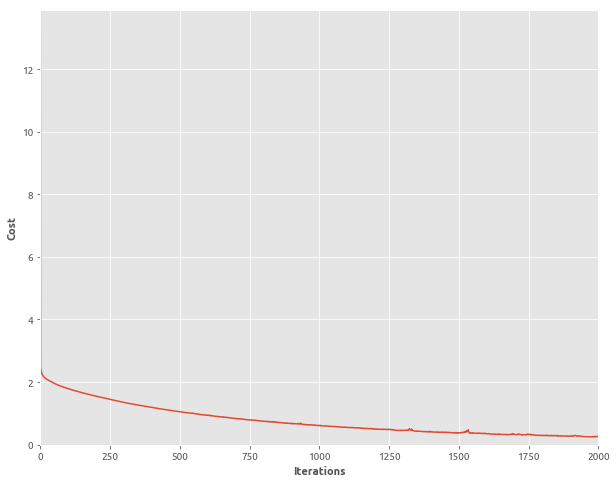

('F-Score:', 0.341)
('Precision:', 0.341)
('recall:', 0.341)
('support:', None)


In [63]:
from sklearn.metrics import precision_recall_fscore_support
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
print("Precision:", round(p,3))
print("recall:", round(r,3))
print("support:", s)